In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import parse
import multiprocessing
from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras_preprocessing.sequence import pad_sequences
import unicodedata
import html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
# Importing Logistics Support Reviews dataset

logistics_reviews = pd.read_csv("logistics.csv")
final_df=logistics_reviews

In [78]:
final_df.head(20)

,Review,Sentiment
0,Good and fast service And Recommend,Positive
1,"Disgusting service, i Hat this courier company",Negative
2,Very very bad service,Negative
3,Excellent service,Positive
4,Their service is so good I am satisfied,Positive
5,Very bad service Specially for home delivery,Negative
6,"worst one no customers services, rude behaviour",Negative
7,its make a important rule in our life,Positive
8,need to improve customer service,Positive
9,Worst service ever Their employees are illite...,Negative


In [79]:
path = r'./data'

In [80]:
final_df.to_csv(path+'/'+'final_submission.csv', index=False) 
print("Final Submission File SAVED!")
print("Final File Shape: ", final_df.shape)
final_df.head()

Final Submission File SAVED!
Final File Shape:  (10153, 2)


,Review,Sentiment
0,Good and fast service And Recommend,Positive
1,"Disgusting service, i Hat this courier company",Negative
2,Very very bad service,Negative
3,Excellent service,Positive
4,Their service is so good I am satisfied,Positive


In [81]:
#Checking if any row has null values
final_df['Sentiment'].isnull().values.sum() 

0

## Data Preprocessing

In [82]:
# Creating a cleaning function

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [83]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10153 entries, 0 to 10152
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     10150 non-null  object
 1   Sentiment  10153 non-null  object
dtypes: object(2)
memory usage: 158.8+ KB


In [84]:
final_df = final_df[final_df['Review'].notna()]
final_df.shape

(10150, 2)

In [85]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10150 entries, 0 to 10152
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     10150 non-null  object
 1   Sentiment  10150 non-null  object
dtypes: object(2)
memory usage: 237.9+ KB


In [86]:
clean_df = final_df.copy()
clean_df['Review'] = final_df['Review'].apply(clean_text)

In [87]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [88]:
pip install keybert

Note: you may need to restart the kernel to use updated packages.


In [89]:
from keybert import KeyBERT

In [90]:
keyModel = KeyBERT()

In [91]:
clean_high_rated_df =  final_df

In [92]:
doc = ''
for comnt in clean_high_rated_df['Review']:
    doc += comnt+'. '
doc

'Good and fast service And Recommend . Disgusting service, i Hat this courier company . Very very bad service . Excellent service . Their service is so good  I am satisfied . Very bad service  Specially for home delivery . worst one  no customers services, rude behaviour . its make a important rule in our life. need to improve customer service. Worst service ever  Their employees are illiterate and their behavior is like a terrotist!. Worst service ever  Every single employee is a thief . Good service All Country. Never send food items via them  They eat the food items and later say the parcel has been lost . The worst courier service of our country. good delivery surveys,24-48 ghonta delivery , thank for fast delivery service . Worst service ever  They even don’t know how to behave with customers  Their stuff are so rude . I delivered a photo frame and a mug to my close friend through this service, it was well and protectively wrapped in bubble wrap . Total rubbish, totally third clas

## Classifying reviews with positive and negative experiences

In [142]:
df = pd.read_csv('./data/final_submission.csv')
#df=df.astype(str)
df.tail(150)

,Review,Sentiment
10003,DDS,Positive
10004,"Dawn on a Distant Shore: I found ""Dawn on a Di...",Positive
10005,Lovely Romance: The product was a bit on the l...,Positive
10006,Not Worth My Time: I was hoping to find anothe...,Negative
10007,A Strong 4,Positive
...,...,...
10148,A revelation of life in small town America in ...,Positive
10149,Great biography of a very interesting journali...,Positive
10150,Interesting Subject; Poor Presentation: You'd ...,Negative
10151,Don't buy: The box looked used and it is obvio...,Negative


In [143]:
df = df[df['Review'].notna()]
df.shape

(10150, 2)

In [144]:
df.Review[10006]

"Not Worth My Time: I was hoping to find another series that would be similar to Diana Gabaldon's deliverys, but I was very disappointed"

In [145]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [146]:
sia.polarity_scores(df.Review[10006])

{'neg': 0.221, 'neu': 0.708, 'pos': 0.071, 'compound': -0.6152}

In [147]:
sia.polarity_scores(df.Review[0])

{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.6597}

In [148]:
df = df.reset_index()

In [149]:
# Running the polarity score throughout the dataframe
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    myid = i
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10150 [00:00<?, ?it/s]

In [150]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
0,0.000,0.426,0.574,0.6597
1,0.405,0.595,0.000,-0.5267
2,0.576,0.424,0.000,-0.6214
3,0.000,0.213,0.787,0.5719
4,0.000,0.424,0.576,0.7786
...,...,...,...,...
10145,0.000,1.000,0.000,0.0000
10146,0.000,0.659,0.341,0.8976
10147,0.246,0.664,0.090,-0.5719
10148,0.000,1.000,0.000,0.0000


In [151]:
sum(vaders.neg)/len(vaders.neg)

0.09681290640394066

In [152]:
sum(vaders.pos)/len(vaders.neg)

0.1800748768472911

In [153]:
sum(vaders.neu)/len(vaders.neg)

0.7219306403940888

In [154]:
vaders = pd.DataFrame(res).T
vaders = pd.concat([vaders, df], axis=1)

In [155]:
vaders.head()

,neg,neu,pos,compound,index,Review,Sentiment
0,0.000,0.426,0.574,0.6597,0,Good and fast service And Recommend,Positive
1,0.405,0.595,0.000,-0.5267,1,"Disgusting service, i Hat this courier company",Negative
2,0.576,0.424,0.000,-0.6214,2,Very very bad service,Negative
3,0.000,0.213,0.787,0.5719,3,Excellent service,Positive
4,0.000,0.424,0.576,0.7786,4,Their service is so good I am satisfied,Positive


 ## Plot Vader Results

Text(0.5, 1.0, 'Compound Score by App Rating')

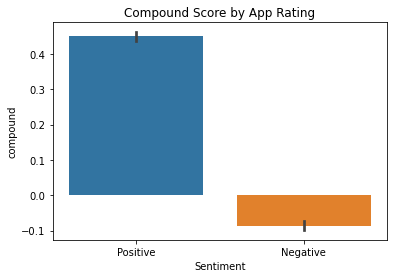

In [156]:
ax = sns.barplot(data=vaders, x='Sentiment', y='compound')
ax.set_title('Compound Score by App Rating')

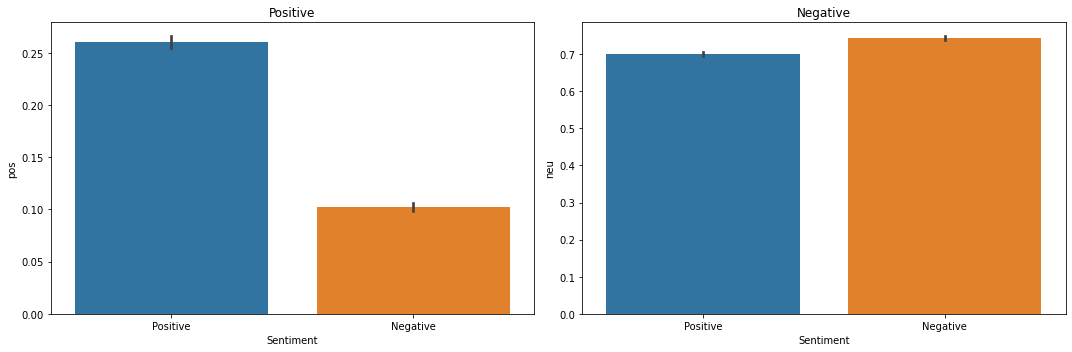

In [157]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.barplot(data=vaders, x='Sentiment', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Sentiment', y='neu', ax=axs[1])

axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Pretrained Model

In [158]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [159]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [160]:
def polarity_scores_roberta(example): # Creating a function for evaluating roberta model
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [161]:
res = {} # Empty dictionary
for i, row in tqdm(df.iterrows(), total=len(df)): # Looping through all the content
    try:
        text = row['Review'] # getting the text
        myid = i # getting the index
        vader_result = sia.polarity_scores(text) # getting the polarity scores
        vader_result_rename = {}
        for key, value in vader_result.items(): # looping through all the outputs
            vader_result_rename[f"vader_{key}"] = value # Renaming the model for vader
        roberta_result = polarity_scores_roberta(text) # evaluating the text using roberta model
        both = {**vader_result, **roberta_result} # saving both values
        res[myid] = both
    except RuntimeError: # catching exceptions for the comments which are too long
        print(f'Broke for id {myid}')

  0%|          | 0/10150 [00:00<?, ?it/s]

In [162]:
results_df = pd.DataFrame(res).T
results_df = pd.concat([results_df, vaders.drop(['pos', 'neg', 'neu', 'compound'], axis=1)], axis=1)
results_df

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,index,Review,Sentiment
0,0.000,0.426,0.574,0.6597,0.003471,0.062317,0.934211,0,Good and fast service And Recommend,Positive
1,0.405,0.595,0.000,-0.5267,0.962331,0.032200,0.005468,1,"Disgusting service, i Hat this courier company",Negative
2,0.576,0.424,0.000,-0.6214,0.933663,0.058482,0.007855,2,Very very bad service,Negative
3,0.000,0.213,0.787,0.5719,0.014847,0.122382,0.862771,3,Excellent service,Positive
4,0.000,0.424,0.576,0.7786,0.002352,0.010750,0.986898,4,Their service is so good I am satisfied,Positive
...,...,...,...,...,...,...,...,...,...,...
10145,0.000,1.000,0.000,0.0000,0.022801,0.635342,0.341856,10148,A revelation of life in small town America in ...,Positive
10146,0.000,0.659,0.341,0.8976,0.001796,0.025679,0.972525,10149,Great biography of a very interesting journali...,Positive
10147,0.246,0.664,0.090,-0.5719,0.559583,0.342153,0.098264,10150,Interesting Subject; Poor Presentation: You'd ...,Negative
10148,0.000,1.000,0.000,0.0000,0.813296,0.173853,0.012851,10151,Don't buy: The box looked used and it is obvio...,Negative


In [163]:
sum(results_df.roberta_neg)/len(results_df.roberta_neg)

0.34063061325356087

In [164]:
results_df = results_df.drop([3403], axis=0)

In [165]:
results_df.columns

Index(['neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'index', 'Review', 'Sentiment'],
      dtype='object')

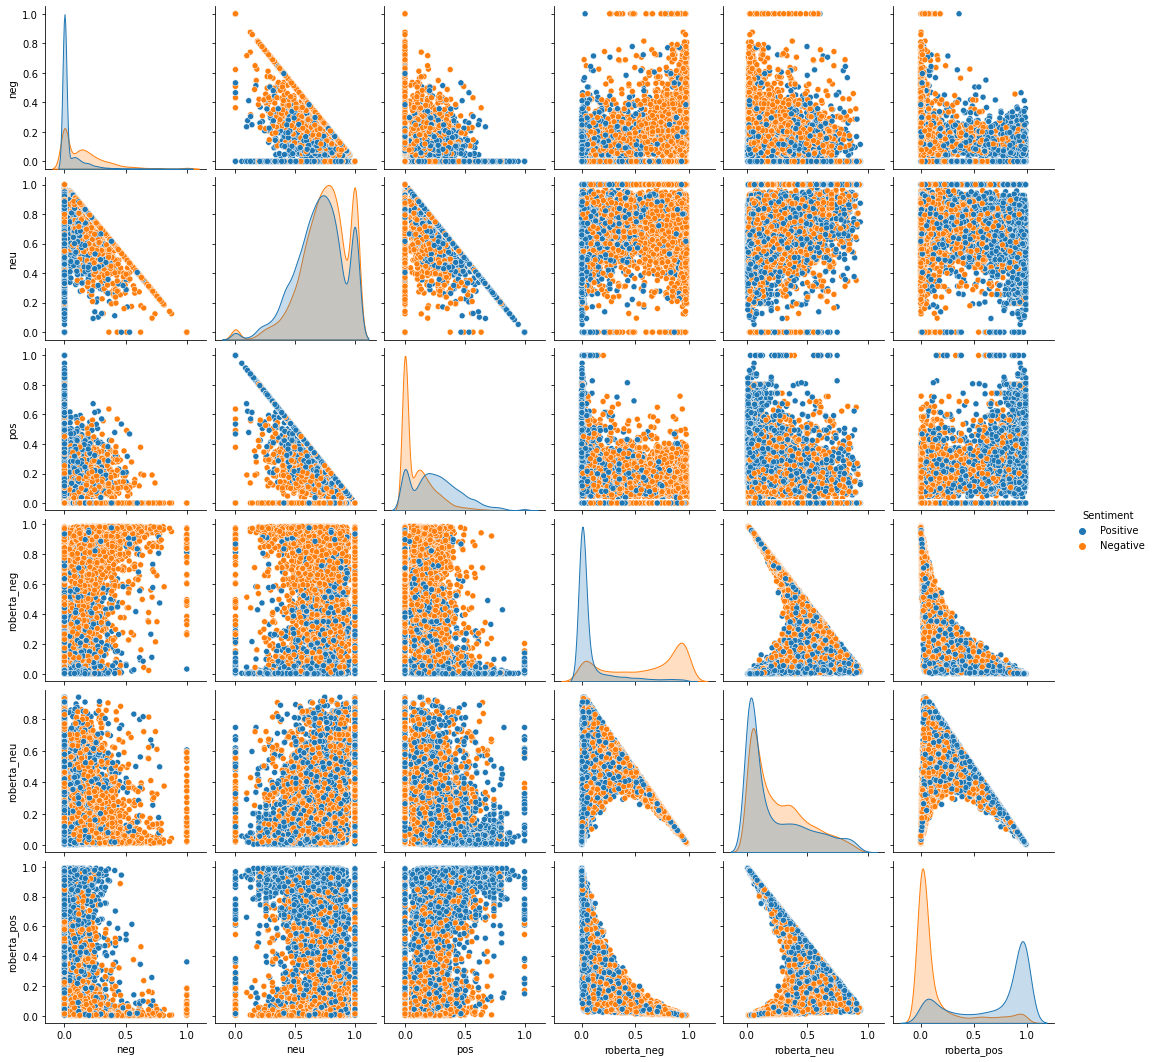

In [166]:
pairplot = sns.pairplot(data=results_df, 
            vars=['neg', 'neu', 'pos', 
                 'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Sentiment',
            palette='tab10')
#pairplot.savefig('./results/vader_vs_roberta.jpg')
plt.show()

## Comparing the results from the two models:
- The roberta model had a better result
- The vader model showed a scattered result
- In the roberta model majority of the positive comments were rated 5, but the model also found a few 1 rated model as positive
- Majority of the neutral components of the comments were found in the 5 rated comments

In [167]:
df

,index,Review,Sentiment
0,0,Good and fast service And Recommend,Positive
1,1,"Disgusting service, i Hat this courier company",Negative
2,2,Very very bad service,Negative
3,3,Excellent service,Positive
4,4,Their service is so good I am satisfied,Positive
...,...,...,...
10145,10148,A revelation of life in small town America in ...,Positive
10146,10149,Great biography of a very interesting journali...,Positive
10147,10150,Interesting Subject; Poor Presentation: You'd ...,Negative
10148,10151,Don't buy: The box looked used and it is obvio...,Negative


In [203]:
df['Class'] = np.where(df['Sentiment'] == 'Positive', 1, 0)
df

,index,Review,Sentiment,Reviewt,Class
0,0,Good and fast service And Recommend,Positive,good fast service recommend,1
1,1,"Disgusting service, i Hat this courier company",Negative,disgust service hat courier company,0
2,2,Very very bad service,Negative,bad service,0
3,3,Excellent service,Positive,excellent service,1
4,4,Their service is so good I am satisfied,Positive,service good satisfy,1
...,...,...,...,...,...
10145,10148,A revelation of life in small town America in ...,Positive,revelation life small town america early thoug...,1
10146,10149,Great biography of a very interesting journali...,Positive,great biography interest journalist biography ...,1
10147,10150,Interesting Subject; Poor Presentation: You'd ...,Negative,interest subject poor presentation youd hardpr...,0
10148,10151,Don't buy: The box looked used and it is obvio...,Negative,dont buy box look use obviously new,0


## Preprocessing
- Casing
- Noise Removal
- Tokenization
- Stopword Removal
- Text Normalization (Stemming and Lemmatization)

In [168]:
# Creating a cleaning function

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [169]:
clean_text(df.Review[0])

'good fast service recommend'

In [170]:
df.Review[0]

'Good and fast service And Recommend '

In [171]:
df['Reviewt'] = df['Review'].apply(clean_text)

## Vectorizing Tokens

In [204]:
X = df.Review # Input data
y = df.Class # Targetted class

In [205]:
X

0                     Good and fast service And Recommend 
1          Disgusting service, i Hat this courier company 
2                                   Very very bad service 
3                                       Excellent service 
4                Their service is so good  I am satisfied 
                               ...                        
10145    A revelation of life in small town America in ...
10146    Great biography of a very interesting journali...
10147    Interesting Subject; Poor Presentation: You'd ...
10148    Don't buy: The box looked used and it is obvio...
10149                      Beautiful Pen and Fast Delivery
Name: Review, Length: 10150, dtype: object

In [174]:
corpus = []
corpus = df.Review.copy()
corpus # creating a corpus using the comments from the data frame

0                     Good and fast service And Recommend 
1          Disgusting service, i Hat this courier company 
2                                   Very very bad service 
3                                       Excellent service 
4                Their service is so good  I am satisfied 
                               ...                        
10145    A revelation of life in small town America in ...
10146    Great biography of a very interesting journali...
10147    Interesting Subject; Poor Presentation: You'd ...
10148    Don't buy: The box looked used and it is obvio...
10149                      Beautiful Pen and Fast Delivery
Name: Review, Length: 10150, dtype: object

In [175]:
from keras.preprocessing.text import Tokenizer # importing tokenizer
tokenizer = Tokenizer(oov_token='<nothing>') # creating tokenizer instance and, labeling out of vocabulary words as <nothing>

In [176]:
tokenizer.fit_on_texts(corpus) # Fitting the corpus in the tokenizer to generate tokens for each of the comments

In [177]:
max(tokenizer.word_index) # Looking for the word that occured the most

'😡😡'

In [178]:
tokenizer.word_counts

OrderedDict([('good', 1053),
             ('and', 4316),
             ('fast', 88),
             ('service', 142),
             ('recommend', 76),
             ('disgusting', 6),
             ('i', 5543),
             ('hat', 2),
             ('this', 5395),
             ('courier', 17),
             ('company', 128),
             ('very', 935),
             ('bad', 351),
             ('excellent', 262),
             ('their', 140),
             ('is', 3474),
             ('so', 686),
             ('am', 263),
             ('satisfied', 28),
             ('specially', 3),
             ('for', 2344),
             ('home', 58),
             ('delivery', 2420),
             ('worst', 246),
             ('one', 1043),
             ('no', 397),
             ('customers', 6),
             ('services', 3),
             ('rude', 10),
             ('behaviour', 4),
             ('its', 223),
             ('make', 159),
             ('a', 5294),
             ('important', 29),
             ('rul

In [179]:
len(tokenizer.word_counts) # Counting the number of different words

15385

In [180]:
tokenizer.document_count # Counting the number of comments which were converter into tokens

10150

In [181]:
sequences = tokenizer.texts_to_sequences(corpus)
sequences 

[[26, 6, 255, 176, 6, 293],
 [2485, 176, 3, 5096, 4, 1106, 193],
 [29, 29, 62, 176],
 [89, 176],
 [180, 176, 9, 33, 26, 3, 88, 725],
 [29, 62, 176, 4021, 12, 376, 11],
 [94, 27, 57, 2486, 4022, 1687, 3323],
 [104, 151, 5, 695, 2487, 13, 156, 155],
 [232, 8, 2019, 558, 176],
 [94, 176, 49, 180, 3324, 32, 7303, 6, 180, 1849, 9, 35, 5, 7304],
 [94, 176, 49, 187, 543, 7305, 9, 5, 7306],
 [26, 176, 31, 674],
 [117,
  1472,
  1300,
  876,
  3325,
  122,
  68,
  1688,
  2,
  1300,
  876,
  6,
  656,
  128,
  2,
  1572,
  48,
  79,
  397],
 [2, 94, 1106, 176, 7, 156, 674],
 [26, 11, 7307, 1473, 3326, 7308, 11, 816, 12, 255, 11, 176],
 [94,
  176,
  49,
  68,
  108,
  5097,
  142,
  90,
  8,
  7309,
  23,
  2486,
  180,
  604,
  32,
  33,
  1687],
 [3,
  877,
  5,
  1573,
  2205,
  6,
  5,
  4023,
  8,
  17,
  696,
  454,
  194,
  4,
  176,
  10,
  14,
  64,
  6,
  7310,
  2853,
  13,
  2488,
  4024],
 [605, 3327, 427, 1155, 282, 283, 176, 930, 1574],
 [29, 29, 590, 558, 176],
 [51, 1575],
 [29

In [182]:
sequences = pad_sequences(sequences,padding='post') # padding the sentences for a symmetric matrix

In [183]:
sequences

array([[  26,    6,  255, ...,    0,    0,    0],
       [2485,  176,    3, ...,    0,    0,    0],
       [  29,   29,   62, ...,    0,    0,    0],
       ...,
       [ 202,  922,  145, ...,    0,    0,    0],
       [  54,   75,    2, ...,    0,    0,    0],
       [ 223, 4228,    6, ...,    0,    0,    0]])

In [184]:
sequences[0]

array([ 26,   6, 255, 176,   6, 293,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [185]:
len(sequences[0]) # The input lenth of the model

212

In [206]:
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size=0.2, random_state=0) #Splitting the data into train and test

In [207]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (8120, 212)
X_test:  (2030, 212)
y_train:  (8120,)
y_test:  (2030,)


In [208]:
y_test

5716    1
7947    0
9119    1
2250    0
8953    1
       ..
3380    1
8545    0
7424    1
394     1
8610    0
Name: Class, Length: 2030, dtype: int32

## Model

In [188]:
#pip install Bidirectional

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the vocabulary size and embedding vector size
voc_size = 10000
embedding_vector_features = 100

# Define the input shape
input_length = 212

# Create the LSTM model
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=input_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 212, 100)          1000000   
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [226]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

## Creating model
embedding_vector_features = 40
model1 = Sequential()
model1.add(Embedding(10000, embedding_vector_features, input_length=212))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 212, 40)           400000    
                                                                 
 bidirectional_16 (Bidirecti  (None, 200)              112800    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 201       
                                                                 
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [227]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_22/embedding_17/embedding_lookup' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_7384\3828715407.py", line 1, in <cell line: 1>
      model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_22/embedding_17/embedding_lookup'
indices[13,4] = 10530 is not in [0, 10000)
	 [[{{node sequential_22/embedding_17/embedding_lookup}}]] [Op:__inference_train_function_75707]

In [224]:
### Finally Training
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_20/embedding_15/embedding_lookup' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_7384\2594754880.py", line 2, in <cell line: 2>
      model.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=5, batch_size=128)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_20/embedding_15/embedding_lookup'
indices[127,0] = 14821 is not in [0, 10000)
	 [[{{node sequential_20/embedding_15/embedding_lookup}}]] [Op:__inference_train_function_68319]

In [ ]:
model1.save('LSTM_APPREVIEW_CLASSIFIER.h5') #Saving the model

In [ ]:
# Test input
a = ["Can't find a single job! One of the worst apps ever!"]

# Creating a function to test on sentences
def predicting_sentiment(sentence_list):
    a = tokenizer.texts_to_sequences(sentence_list)
    a = np.array(a)
    a = pad_sequences(a, padding='post', maxlen = 78)
    a = a.reshape((a.shape[0], a.shape[1], 1))
    prediction = model1.predict(a)
    if prediction > 0.5:
        print("The sentiment is: Positive", prediction)
    else:
        print("The sentiment is: Negative", prediction)